# 파이토치 빠르게 시작하기

## 파이토치 설치와 라이브러리 임포트

In [1]:
#!pip install torch torchvision

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os 

## 패션 MNIST 데이터셋 다운로드

In [3]:
# 트레이닝 데이터셋을 다운로드한다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# 테스트 데이터셋을 다운로드한다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

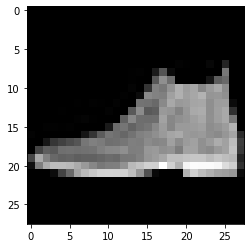

In [4]:
img = test_data[0][0].numpy() * 255
img = img.astype(np.int32).reshape(28,28)
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.imshow(img, cmap="gray")
#Z = np.array([[20,5,2],[2,20,3],[11,2,20]])
#plt.imshow(Z, cmap = cm.gray)
#plt.show()

## 배치사이즈를 설정하고 데이터 로더를 정의

In [5]:
batch_size = 64

# 데이터로더 정의
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## CPU 대신에 GPU를 사용하도록 설정하기

In [6]:
device = "cuda" if torch.cuda.is_available() else  "cpu"

# 위 코드는 아래 코드 내용을 한 줄로 표현한 것
'''
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
'''

print(f"Using {device} device")

Using cpu device


## 간단한 NN 작성

784x512, 512x512, 512x10의 노드를 가진 네트워크를 구성한다.

In [7]:
class NerualNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NerualNetwork().to(device) # 변수를 cuda로 보냄
print(model)

NerualNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 하이퍼파라미터를 구성
손실 함수와 최적화 알고리즘을 선택한다.

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # 0.001

## 학습 및 평가 함수 정의

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # 모델이 학습하도록 트레인 단계를 활성화
    
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 모델의 에러를 계산
        pred = model(X) # 포워드 연산
        loss = loss_fn(pred, y) # loss 연산
        
        # 역전파
        optimizer.zero_grad() # 매 이터레이션마다 그래디언트를 초기화
        loss.backward() # 역전파가 진행되어 w,r,t 그래프잎의 기울기를 계산한다.
        optimizer.step() # 가중치 업데이트
        
        if batch % 100 == 0: # 매 100회 배치를 돌 때마다 리포트 수행
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # 평가를 수행한다는 의미
    test_loss, correct = 0, 0
    
    with torch.no_grad(): # 그라데이션 계산을 비활성화
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)

            # 모델의 에러를 계산
            pred = model(X) # 포워드 연산
            test_loss += loss_fn(pred, y).item() # loss 연산
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

    
epochs = 5
for t in range(epochs):
    print(f'Epoch {t+1}\n--------------------------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
--------------------------------------
loss: 2.304574 [    0/60000]
loss: 2.288394 [ 6400/60000]
loss: 2.272907 [12800/60000]
loss: 2.262149 [19200/60000]
loss: 2.263522 [25600/60000]
loss: 2.228719 [32000/60000]
loss: 2.233218 [38400/60000]
loss: 2.204882 [44800/60000]
loss: 2.195437 [51200/60000]
loss: 2.165795 [57600/60000]
Test Error: 
 Accuracy: 42.9%, Avg loss: 2.163326

Epoch 2
--------------------------------------
loss: 2.180132 [    0/60000]
loss: 2.171099 [ 6400/60000]
loss: 2.116764 [12800/60000]
loss: 2.126272 [19200/60000]
loss: 2.100520 [25600/60000]
loss: 2.029132 [32000/60000]
loss: 2.058379 [38400/60000]
loss: 1.986299 [44800/60000]
loss: 1.983852 [51200/60000]
loss: 1.916324 [57600/60000]
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.917415

Epoch 3
--------------------------------------
loss: 1.964308 [    0/60000]
loss: 1.934472 [ 6400/60000]
loss: 1.819469 [12800/60000]
loss: 1.841753 [19200/60000]
loss: 1.764568 [25600/60000]
loss: 1.697927 [32000/60000]
los

## 모델 저장과 불러오기

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Pytorch 모델의 상태를 model.pth에 저장했다.")

In [ ]:
mode = NerualNetwork()
model.load_state_dict(torch.load("model.pth"))

## 불러온 모델을 사용해 예측 수행하기

In [ ]:
classes = [
    "T-shirt/top",
    "Trouse",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
img = test_data[0][0].numpy() * 255
img = img.astype(np.int32).reshape(28,28)
